# **GENDER CLASSIFICATION**

The following is an experiment of several pretrained models for a gender classification project using 5000 photos taken from the CelebA dataset. The models attempted are Inception V3, ResNet 50, and EfficientNet B2. These models are considered to have high accuracy and faster. This experiment utilizes the PyTorch framework.

## **0. Getting Setup**

In [1]:
!pip install efficientnet-pytorch

# import some dependencies
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models import resnet50, ResNet50_Weights
from efficientnet_pytorch import EfficientNet
from torch.optim import Adam, SGD
from tqdm import tqdm
import time
from timeit import default_timer as timer
from PIL import Image

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4

In [2]:
# try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
# setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# set hyperparameter
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
NUM_EPOCHS = 5
LR = 0.001

## **1. Get Data and Exploratory Data Analysis**


The dataset and attribute files are stored in Google Drive.

### a. Prepare the data directory

In [5]:
# setup the directory path
data_path = "/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition"
image_dir = "/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Images"

# look in the data path
os.listdir(data_path)

['class_identity.txt',
 'gender_classification.csv',
 'list_attribute.txt',
 'gender_classification.xlsx',
 'Images',
 'list_attribute_edited.txt',
 'data_filtered.txt',
 'data_filtered_gender.txt',
 'Face_Recognition_Amar Version 2.ipynb',
 'Face_Recognition_Amar Version 1.ipynb',
 'gender_distribution.png',
 'training_result.png',
 'confusion_matrix.png',
 'Foto Profil 1.jpeg']

### b. Open the attribute data

In [6]:
# open the attribute file
attribute_data = pd.read_csv(data_path+"/list_attribute_edited.txt", delimiter=" ", skipinitialspace=True)
attribute_data.drop(columns=["Unnamed: 41"], inplace=True)
attribute_data.replace(to_replace=-1, value=0, inplace=True)
attribute_data.head()

,Image_Id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


### c. Filter the gender data

The attributes used are only "Image_Id" and "Male". "Image_Id" is filtered according to the photo files available in Google Drive.

In [7]:
# filter the data with available images only (in this case we only have 5000 images)
photo_dir = os.listdir(data_path+"/Images") # all filenames list for image in the folder "Images"
image_avail = [img for img in photo_dir if img in attribute_data["Image_Id"].tolist()] # matching data between available image and dataframe
image_filtered = attribute_data[attribute_data["Image_Id"].isin(image_avail)].reset_index(drop=True).iloc[:5000] # delete unused image id
image_filtered_gender = image_filtered[["Image_Id", "Male"]]
image_filtered_gender

,Image_Id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


### d. Analyze data with visualization

After examining its distribution, it turns out that the data distribution between males and females is imbalance. There is a difference, with 906 fewer male data points to achieve balance. Good data is data with balanced classes. One way to address this data imbalance is by using data augmentation in the data preprocessing stage later on.

<ipython-input-8-9e8c54776cd3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=image_filtered_gender, x="Male", palette="bright")


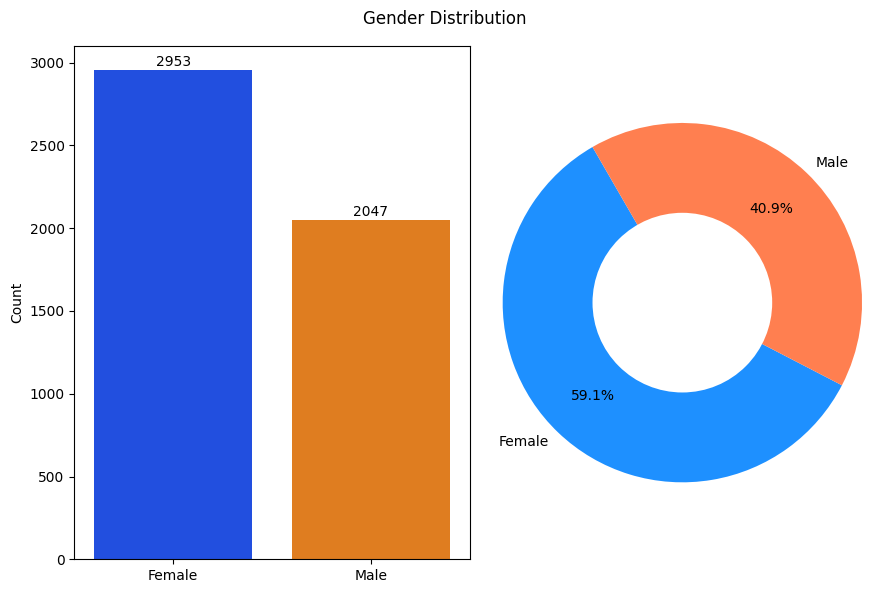

In [8]:
# visualize data distribution
plt.figure(figsize=(9,6))

# subplot 1: countplot
plt.subplot(1, 2, 1)
sns.countplot(data=image_filtered_gender, x="Male", palette="bright")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Female", "Male"])

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+25, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# subplot 2: pieplot
plt.subplot(1, 2, 2)
gender_count = image_filtered_gender["Male"].value_counts()
plt.pie(gender_count, labels=["Female", "Male"],
        autopct='%1.1f%%',
        startangle=120,
        colors=["dodgerblue", "coral"],
        labeldistance=1.075, # move the gender label position
        pctdistance=0.72) # move the percentage label position
center_circle = plt.Circle((0,0), 0.5, fc="white")
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.suptitle("Gender Distribution")

plt.axis("equal")
plt.tight_layout()
plt.show()

# in this case, the data distribution is imbalance
# so in the later step, we will handle it

In [9]:
# the difference between male and female tare
gender_count = image_filtered_gender["Male"].value_counts()
difference_gender = gender_count[0]-gender_count[1]

print("Difference Male and Female =", difference_gender)

Difference Male and Female = 906


All data have the same shape, which is (218, 178, 3). This means the height is 218 pixels, the width is 178 pixels, and there are 3 color channels (RGB). Based on the displayed image data, there is 1 mislabeled data where the photo shows a female, but the label indicates male. There may be several data errors like this. This is caused by errors in inputting data and classes in the attribute file. This can only be addressed by correcting the attribute file manually. In this project, an automatic way to solve this problem is not yet known.

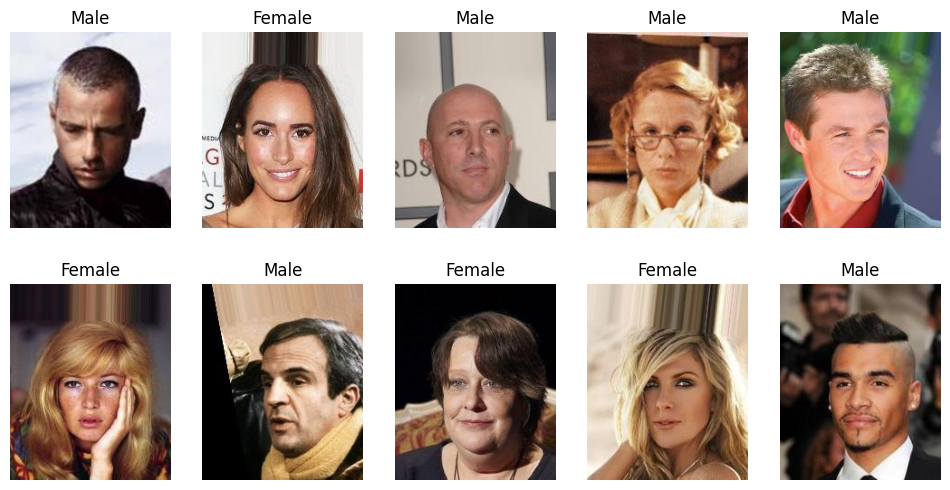

In [10]:
# visualize sample images
np.random.seed(32)
data_sample = image_filtered_gender.sample(10) # get 10 random samples from the DataFrame
image_file = data_sample["Image_Id"]
image_label = data_sample["Male"]

def display_images(image_file, image_labels, start_index=0):
    n_rows = 2
    n_cols = 5
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))
    axes = axes.flatten() # convert 2D array of axes into 1D array

    for i, (file, label) in enumerate(zip(image_file, image_label)):
        file_path = os.path.join(image_dir, file)
        image = plt.imread(file_path)
        axes[i].imshow(image)
        axes[i].axis("off")

        if label == 1:
            axes[i].set_title("Male")
        else:
            axes[i].set_title("Female")

    # remove unused axes
    for i in range(10, len(axes)):
        axes[i].remove()

    plt.show()

display_images(image_file, image_label)

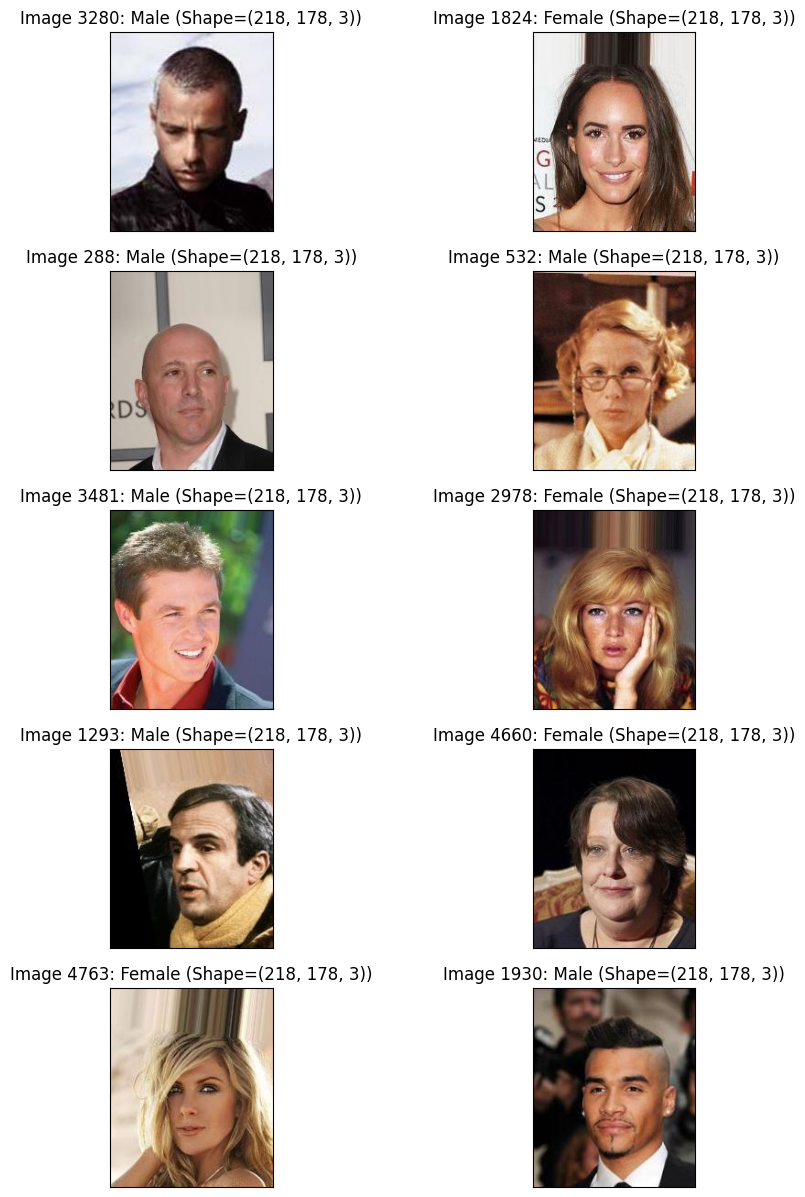

In [11]:
# display some images to know the image shape
np.random.seed(32)

# slect 10 random row indices from the dataframe
row_indices = np.random.choice(image_filtered_gender.index, size=10, replace=False)

# create a new figure with 10 subplots vertical
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes = axes.flatten() # convert 2D array of axes into 1D array

# loop over the selected row indices and visualize the corresponding images
for i, idx in enumerate(row_indices):
    # load the image file
    img_file = os.path.join(image_dir, image_filtered_gender.loc[idx, "Image_Id"])
    img = plt.imread(img_file)

    # display the image in the current subplot
    axes[i].imshow(img)

    # add the image label and shape
    label = "Male" if image_filtered_gender.loc[idx, "Male"] == 1 else "Female"
    img_shape = img.shape
    axes[i].set_title(f"Image {idx+1}: {label} (Shape={img_shape})")

    # hide the x and y axes
    axes[i].xaxis.set_major_locator(plt.NullLocator())
    axes[i].yaxis.set_major_locator(plt.NullLocator())

# show the plot
plt.show()

# all image shape is same, it is (218, 178, 3)
# there is image has wrong label

## **2. Split Dataset and Create Custom Dataset**

* The main requirements to prepare before using pretrained models and training processes in the PyTorch framework are preparing training and testing data, creating a custom dataset class to load the dataset according to the PyTorch format, and creating a dataloader that will be used for the model training process.

* Before applying the custom dataset class and dataloader to the model training process, both of them must ensure that their code runs correctly. The following steps are to ensure that both codes can run properly.

### a. Split dataset

In [12]:
# split data test to train and test through the dataframe (attribute data)
# train 80% test 20%
from sklearn.model_selection import train_test_split

X = image_filtered_gender["Image_Id"] # feature/input : filename
y = image_filtered_gender["Male"] # label/output : gender

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train Data = ", len(X_train))
print("Test Data  = ", len(X_test))

Train Data =  4000
Test Data  =  1000


### b. Create custom dataset (according to PyTorch requirements)

In [13]:
# create custom dataset class
class CelebADataset(Dataset):
    def __init__(self, data_dir, image_ids, labels, transform=None):
        self.data_dir = data_dir
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids.iloc[idx]
        image_path = os.path.join(self.data_dir, f"{image_id}")
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor([self.labels.iloc[idx]], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

### c. Create transformation and augmentation

In [14]:
# create transformation and augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(), # augmentation to horizontal flip
    transforms.RandomRotation(30), # augmentation to 30 degree rotation
    transforms.ToTensor()
])

# apply custom dataset class
dataset = CelebADataset(image_dir, X_train, y_train, transform=transform)

### d. Create DataLoader

In [15]:
# create data loader
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [16]:
# looking information inside dataloader has made

# get the batch sample in the dataloader
# dataloader contains input and output (feature and label)
inputs, labels = next(iter(dataloader))

# get the number of batches in the dataloader
num_batches = len(dataloader)

# print out the summary
print(f"Dataloader = {dataloader}\n")
print(f"Batch Sample:\nInput Shape = {inputs.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} Batches") # 4000 train data is devided 32
print(f"Number of All Data = {32*num_batches} Data") # previously, each batch was set to contain 32 data

Dataloader = <torch.utils.data.dataloader.DataLoader object at 0x7b71484e7ca0>

Batch Sample:
Input Shape = torch.Size([32, 3, 64, 64])
Label Shape = torch.Size([32, 1])
Labels = [[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0]]
Number of Batches = 125 Batches
Number of All Data = 4000 Data


### e. Visualize the dataloader sample

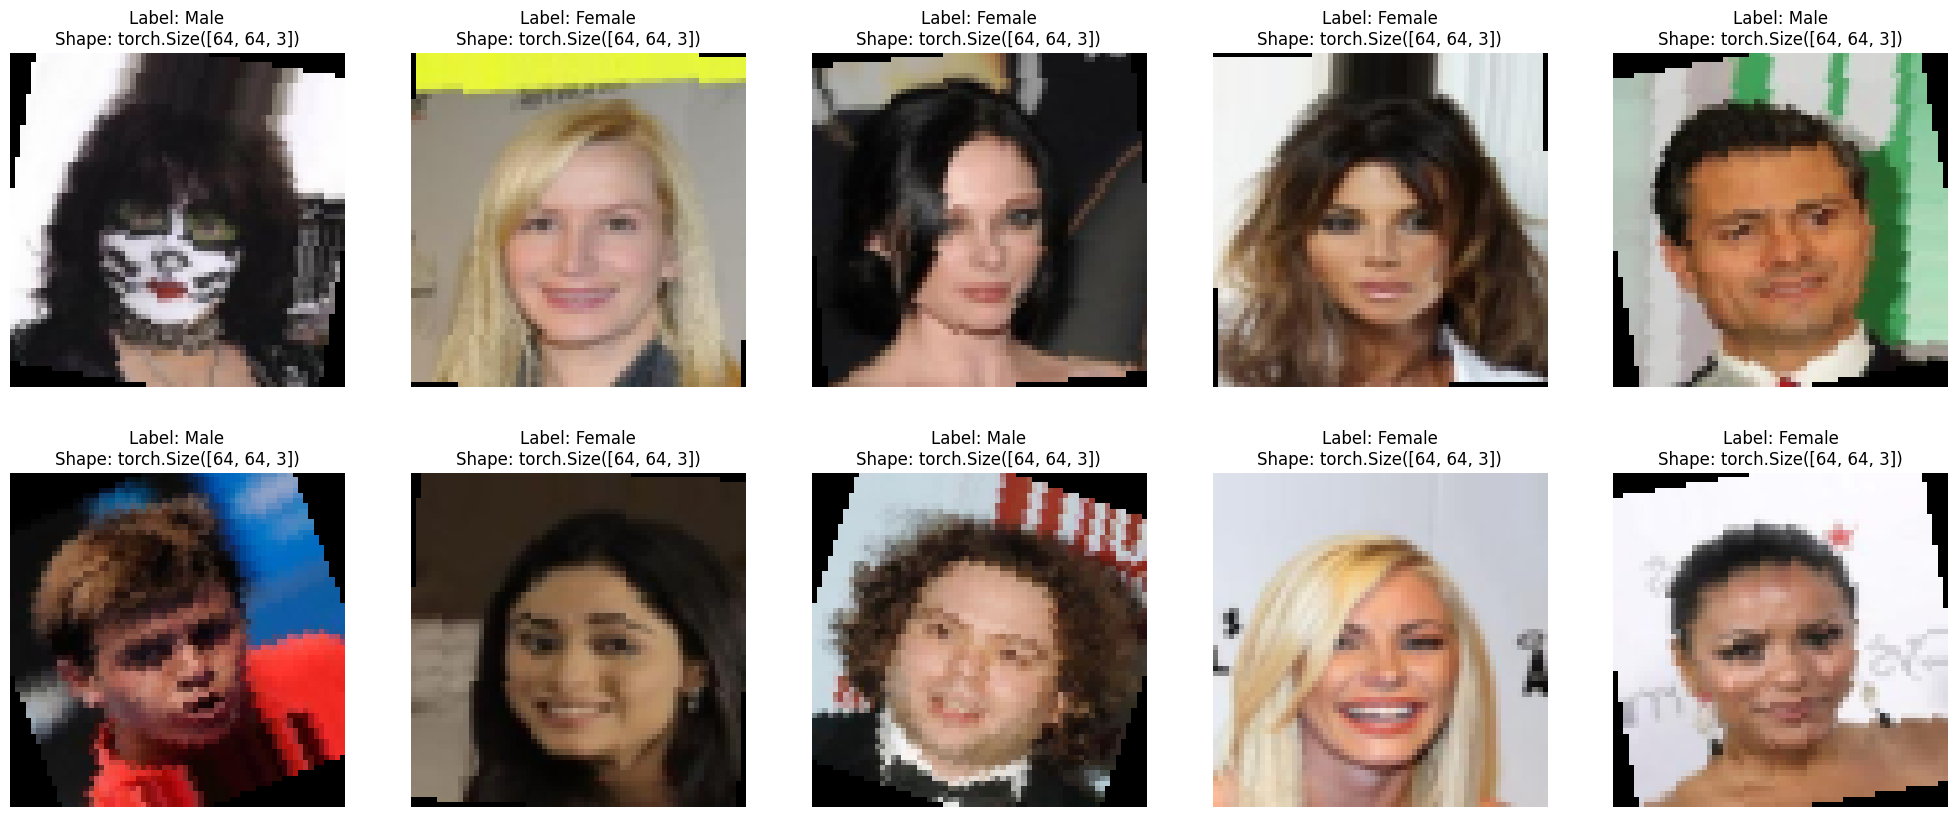

In [17]:
# define label names
label_names = ["Female", "Male"]

# visualize dataloader
dataiter = iter(dataloader)
images, labels = dataiter.__next__()

# plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
for i in range(10):
    images_adjusted = images[i].permute(1, 2, 0)
    ax = axes[i // 5, i % 5]
    ax.imshow(images_adjusted)
    ax.axis("off")
    ax.set_title(f"Label: {label_names[int(labels[i].item())]}\nShape: {images_adjusted.shape}")
plt.show()

## **3. Create DataLoader for Different Models**

This stage involves data preprocessing and preparing the dataloader. Data transformation must comply with the format required by each model. This can be found in the documentation of pretrained models in PyTorch. In addition to data transformation, data augmentation is also added to enrich the dataset and address data imbalance.

### a. DataLoader for Inception V3

In [18]:
# data transformations
train_transform_iv3 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
])

# don't apply augmentation in test data
test_transform_iv3 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

In [19]:
# apply transformation to custom dataset
train_dataset_iv3 = CelebADataset(image_dir, X_train, y_train, transform=train_transform_iv3)
test_dataset_iv3 = CelebADataset(image_dir, X_test, y_test, transform=test_transform_iv3)

In [20]:
# create dataloader
train_dataloader_iv3 = DataLoader(train_dataset_iv3,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

test_dataloader_iv3 = DataLoader(test_dataset_iv3,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False) # don't shuffle on test data

len(train_dataloader_iv3), len(test_dataloader_iv3)

(125, 32)

### b. DataLoader for ResNet 50

In [57]:
# data transformations
train_transform_rn50 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
])

# don't apply augmentation in test data
test_transform_rn50 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [58]:
# apply transformation to custom dataset
train_dataset_rn50 = CelebADataset(image_dir, X_train, y_train, transform=train_transform_rn50)
test_dataset_rn50 = CelebADataset(image_dir, X_test, y_test, transform=test_transform_rn50)

In [59]:
# create dataloader
train_dataloader_rn50 = DataLoader(train_dataset_rn50,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

test_dataloader_rn50 = DataLoader(test_dataset_rn50,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False) # don't shuffle on test data

len(train_dataloader_rn50), len(test_dataloader_rn50)

(125, 32)

### c. DataLoader for EfficientNet B2

In [24]:
# data transformations
train_transform_en2 = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
])

# don't apply augmentation in test data
test_transform_en2 = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
])

In [25]:
# apply transformation to custom dataset
train_dataset_en2 = CelebADataset(image_dir, X_train, y_train, transform=train_transform_en2)
test_dataset_en2 = CelebADataset(image_dir, X_test, y_test, transform=test_transform_en2)

In [26]:
# create dataloader
train_dataloader_en2 = DataLoader(train_dataset_en2,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

test_dataloader_en2 = DataLoader(test_dataset_en2,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False) # don't shuffle on test data

len(train_dataloader_en2), len(test_dataloader_en2)

(125, 32)

## **4. Build The Model**

### a. Inception V3

In [28]:
# load pretrained Inception V3 model
model_iv3 = inception_v3(weights=Inception_V3_Weights.DEFAULT)
model_iv3.fc = nn.Linear(in_features=model_iv3.fc.in_features, out_features=1) # modify fully connected layer

# freeze pretrained layers
for param in model_iv3.parameters():
    param.requires_grad = False

# unfreeze fully connected layer
for param in model_iv3.fc.parameters():
    param.requires_grad = True

model_iv3 = model_iv3.to(device)

In [29]:
summary(model=model_iv3,
        input_size=(32, 3, 299, 299),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Inception3 (Inception3)                  [32, 3, 299, 299]    [32, 1]              3,326,696            Partial
├─BasicConv2d (Conv2d_1a_3x3)            [32, 3, 299, 299]    [32, 32, 149, 149]   --                   False
│    └─Conv2d (conv)                     [32, 3, 299, 299]    [32, 32, 149, 149]   (864)                False
│    └─BatchNorm2d (bn)                  [32, 32, 149, 149]   [32, 32, 149, 149]   (64)                 False
├─BasicConv2d (Conv2d_2a_3x3)            [32, 32, 149, 149]   [32, 32, 147, 147]   --                   False
│    └─Conv2d (conv)                     [32, 32, 149, 149]   [32, 32, 147, 147]   (9,216)              False
│    └─BatchNorm2d (bn)                  [32, 32, 147, 147]   [32, 32, 147, 147]   (64)                 False
├─BasicConv2d (Conv2d_2b_3x3)            [32, 32, 147, 147]   [32, 64, 147, 147]   --                   False
│   

### b. ResNet 50

In [63]:
# load pretrained ResNet 50 model
model_rn50 = resnet50(weights=ResNet50_Weights.DEFAULT)
model_rn50.fc = nn.Linear(in_features=model_rn50.fc.in_features, out_features=1) # modify fully connected layer

# freeze pretrained layers
for param in model_rn50.parameters():
    param.requires_grad = False

# unfreeze fully connected layer
for param in model_rn50.fc.parameters():
    param.requires_grad = True

model_rn50 = model_rn50.to(device)

In [64]:
summary(model=model_rn50,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### c. EfficientNet B2

In [32]:
# load pretrained EfficientNet B2 model
model_en2 = EfficientNet.from_pretrained('efficientnet-b2')
in_features = model_en2._fc.in_features
model_en2._fc = nn.Sequential(nn.Linear(in_features=in_features, out_features=1)) # modify fully connected layer

# freeze pretrained layers
for param in model_en2.parameters():
    param.requires_grad = False

# unfreeze fully connected layer
for param in model_en2._fc.parameters():
    param.requires_grad = True

model_en2 = model_en2.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 134MB/s]


Loaded pretrained weights for efficientnet-b2


In [33]:
summary(model=model_en2,
        input_size=(32, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 1]              --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 288, 288]    [32, 32, 144, 144]   864                  False
│    └─ZeroPad2d (static_padding)                            [32, 3, 288, 288]    [32, 3, 289, 289]    --                   --
├─BatchNorm2d (_bn0)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
├─MemoryEfficientSwish (_swish)                              [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   False
│    └─MBConvBlock (0)                                       [32, 32, 144, 144]   [32, 16,

## **5. Determine Loss Function and Optimizer**

In [34]:
# Inception V3
# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_iv3 = Adam(model_iv3.fc.parameters(), lr=LR)

In [65]:
# ResNet50
# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_rn50 = Adam(model_rn50.fc.parameters(), lr=LR)

In [36]:
# EfficientNet B2
# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_en2 = Adam(model_en2._fc.parameters(), lr=LR)

## **6. Create Train-Test Loop Function**

In [37]:
# Inception V3
# training and testing functions
def train_iv3(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.logits, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.round(torch.sigmoid(outputs.logits))
        correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

def test_iv3(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze().float())  # Use .squeeze() to match the size

            running_loss += loss.item()
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

In [66]:
# ResNet 50
# training and testing functions
def train_rn50(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())  # Use the output tensor directly

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.round(torch.sigmoid(outputs))
        correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

def test_rn50(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze().float())

            running_loss += loss.item()
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

In [39]:
# EfficientNet B2
# training and testing functions
def train_en2(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())  # Use the output tensor directly

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.round(torch.sigmoid(outputs))
        correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

def test_en2(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze().float())

            running_loss += loss.item()
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

## **7. Train The Model**

### a. Result of Inception V3

In [40]:
# training and testing
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train_iv3(model_iv3, train_dataloader_iv3, criterion, optimizer_iv3, device)
    test_loss, test_accuracy = test_iv3(model_iv3, test_dataloader_iv3, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f} | Time: {elapsed_time:.2f}s")

Epoch 1/5 | Train Loss: 0.4559, Train Acc: 0.7963 | Test Loss: 0.3252, Test Acc: 0.8920 | Time: 36.67s


Epoch 2/5 | Train Loss: 0.3257, Train Acc: 0.8732 | Test Loss: 0.2827, Test Acc: 0.8900 | Time: 34.61s


Epoch 3/5 | Train Loss: 0.3006, Train Acc: 0.8752 | Test Loss: 0.2983, Test Acc: 0.8740 | Time: 33.12s


Epoch 4/5 | Train Loss: 0.2840, Train Acc: 0.8802 | Test Loss: 0.2571, Test Acc: 0.8980 | Time: 34.25s


Epoch 5/5 | Train Loss: 0.2753, Train Acc: 0.8805 | Test Loss: 0.2424, Test Acc: 0.9020 | Time: 33.78s


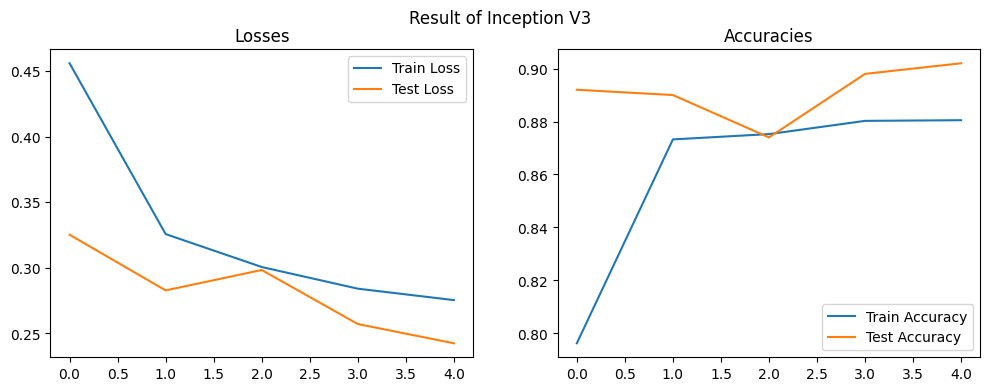

In [41]:
# plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Losses")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracies")
plt.legend()

plt.suptitle("Result of Inception V3")

plt.show()

### b. Result of ResNet 50

In [42]:
# training and testing
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train_rn50(model_rn50, train_dataloader_rn50, criterion, optimizer_rn50, device)
    test_loss, test_accuracy = test_rn50(model_rn50, test_dataloader_rn50, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f} | Time: {elapsed_time:.2f}s")

Epoch 1/5 | Train Loss: 0.4658, Train Acc: 0.8157 | Test Loss: 0.3429, Test Acc: 0.8890 | Time: 28.42s


Epoch 2/5 | Train Loss: 0.3080, Train Acc: 0.8980 | Test Loss: 0.2755, Test Acc: 0.8960 | Time: 27.03s


Epoch 3/5 | Train Loss: 0.2671, Train Acc: 0.9085 | Test Loss: 0.2530, Test Acc: 0.9020 | Time: 27.03s


Epoch 4/5 | Train Loss: 0.2417, Train Acc: 0.9173 | Test Loss: 0.2344, Test Acc: 0.9030 | Time: 26.92s


Epoch 5/5 | Train Loss: 0.2271, Train Acc: 0.9113 | Test Loss: 0.2252, Test Acc: 0.9030 | Time: 26.83s


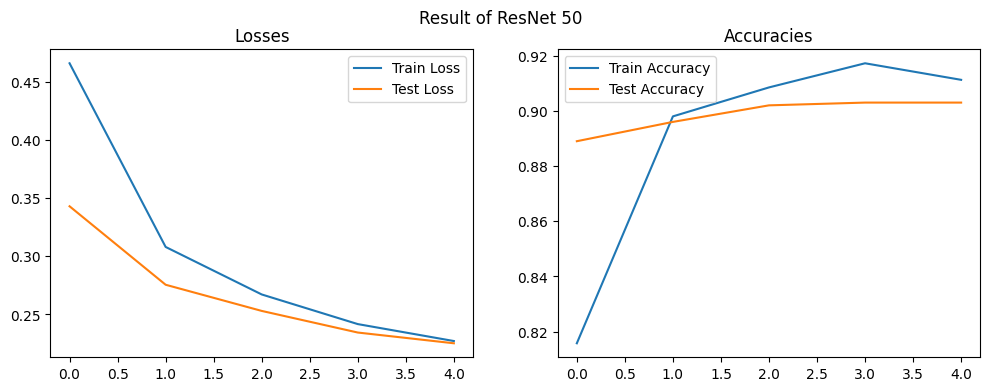

In [43]:
# plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Losses")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracies")
plt.legend()

plt.suptitle("Result of ResNet 50")

plt.show()

### c. Result of EfficientNet B2

In [44]:
# training and testing
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train_en2(model_en2, train_dataloader_en2, criterion, optimizer_en2, device)
    test_loss, test_accuracy = test_en2(model_en2, test_dataloader_en2, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f} | Time: {elapsed_time:.2f}s")

Epoch 1/5 | Train Loss: 0.4491, Train Acc: 0.8210 | Test Loss: 0.3125, Test Acc: 0.9100 | Time: 35.53s


Epoch 2/5 | Train Loss: 0.3063, Train Acc: 0.8932 | Test Loss: 0.2874, Test Acc: 0.9030 | Time: 34.30s


Epoch 3/5 | Train Loss: 0.2810, Train Acc: 0.8892 | Test Loss: 0.2690, Test Acc: 0.9090 | Time: 37.76s


Epoch 4/5 | Train Loss: 0.2627, Train Acc: 0.8975 | Test Loss: 0.2408, Test Acc: 0.9190 | Time: 34.18s


Epoch 5/5 | Train Loss: 0.2536, Train Acc: 0.8962 | Test Loss: 0.2268, Test Acc: 0.9230 | Time: 35.73s


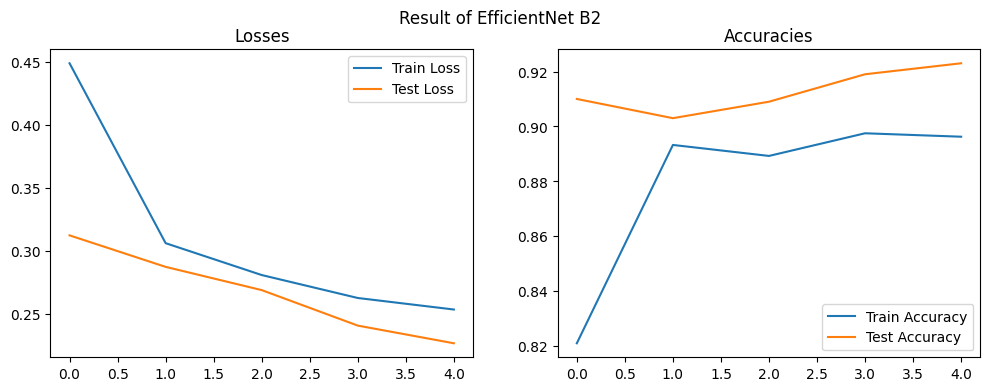

In [45]:
# plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Losses")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracies")
plt.legend()

plt.suptitle("Result of EfficientNet B2")

plt.show()

## **8. Train The Best Model**


From the training results of the three models with the same treatment (same Batch Size, Number of Workers, Learning Rate, Epochs, Loss Function, and Optimizer), EfficientNet B2 has a higher accuracy compared to the other models, achieving 92%. Following that, ResNet 50 achieved 90%, and Inception V3 achieved 90% as well. However, ResNet has a faster training time, less than 30 seconds, while the other models take more than 30 seconds. The difference in accuracy between ResNet 50 and EfficientNet B2 is only 2%. Therefore, ResNet 50 is chosen as the best model here due to its fast training time and high accuracy, achieved in just 5 epochs. Let's to try more epochs on ResNet 50.

In [67]:
# training and testing
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(20):
    start_time = time.time()

    train_loss, train_accuracy = train_rn50(model_rn50, train_dataloader_rn50, criterion, optimizer_rn50, device)
    test_loss, test_accuracy = test_rn50(model_rn50, test_dataloader_rn50, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch + 1}/{20} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f} | Time: {elapsed_time:.2f}s")

Epoch 1/20 | Train Loss: 0.4659, Train Acc: 0.8233 | Test Loss: 0.3398, Test Acc: 0.8900 | Time: 27.12s


Epoch 2/20 | Train Loss: 0.3180, Train Acc: 0.8892 | Test Loss: 0.2761, Test Acc: 0.9000 | Time: 28.69s


Epoch 3/20 | Train Loss: 0.2692, Train Acc: 0.9040 | Test Loss: 0.2514, Test Acc: 0.9040 | Time: 27.84s


Epoch 4/20 | Train Loss: 0.2436, Train Acc: 0.9133 | Test Loss: 0.2350, Test Acc: 0.9040 | Time: 26.85s


Epoch 5/20 | Train Loss: 0.2246, Train Acc: 0.9187 | Test Loss: 0.2240, Test Acc: 0.9080 | Time: 27.10s


Epoch 6/20 | Train Loss: 0.2140, Train Acc: 0.9215 | Test Loss: 0.2142, Test Acc: 0.9130 | Time: 26.95s


Epoch 7/20 | Train Loss: 0.2085, Train Acc: 0.9160 | Test Loss: 0.2115, Test Acc: 0.9140 | Time: 26.81s


Epoch 8/20 | Train Loss: 0.1994, Train Acc: 0.9260 | Test Loss: 0.2052, Test Acc: 0.9210 | Time: 26.63s


Epoch 9/20 | Train Loss: 0.1926, Train Acc: 0.9297 | Test Loss: 0.2054, Test Acc: 0.9200 | Time: 26.70s


Epoch 10/20 | Train Loss: 0.1841, Train Acc: 0.9317 | Test Loss: 0.2023, Test Acc: 0.9200 | Time: 26.68s


Epoch 11/20 | Train Loss: 0.1793, Train Acc: 0.9330 | Test Loss: 0.1968, Test Acc: 0.9190 | Time: 27.62s


Epoch 12/20 | Train Loss: 0.1707, Train Acc: 0.9397 | Test Loss: 0.1926, Test Acc: 0.9250 | Time: 26.33s


Epoch 13/20 | Train Loss: 0.1725, Train Acc: 0.9395 | Test Loss: 0.1929, Test Acc: 0.9260 | Time: 26.30s


Epoch 14/20 | Train Loss: 0.1668, Train Acc: 0.9395 | Test Loss: 0.1929, Test Acc: 0.9260 | Time: 26.33s


Epoch 15/20 | Train Loss: 0.1575, Train Acc: 0.9457 | Test Loss: 0.1877, Test Acc: 0.9240 | Time: 26.46s


Epoch 16/20 | Train Loss: 0.1582, Train Acc: 0.9427 | Test Loss: 0.1890, Test Acc: 0.9280 | Time: 26.50s


Epoch 17/20 | Train Loss: 0.1565, Train Acc: 0.9455 | Test Loss: 0.1873, Test Acc: 0.9220 | Time: 26.49s


Epoch 18/20 | Train Loss: 0.1511, Train Acc: 0.9443 | Test Loss: 0.1898, Test Acc: 0.9310 | Time: 26.67s


Epoch 19/20 | Train Loss: 0.1502, Train Acc: 0.9453 | Test Loss: 0.1862, Test Acc: 0.9260 | Time: 27.95s


Epoch 20/20 | Train Loss: 0.1504, Train Acc: 0.9457 | Test Loss: 0.1870, Test Acc: 0.9260 | Time: 26.38s


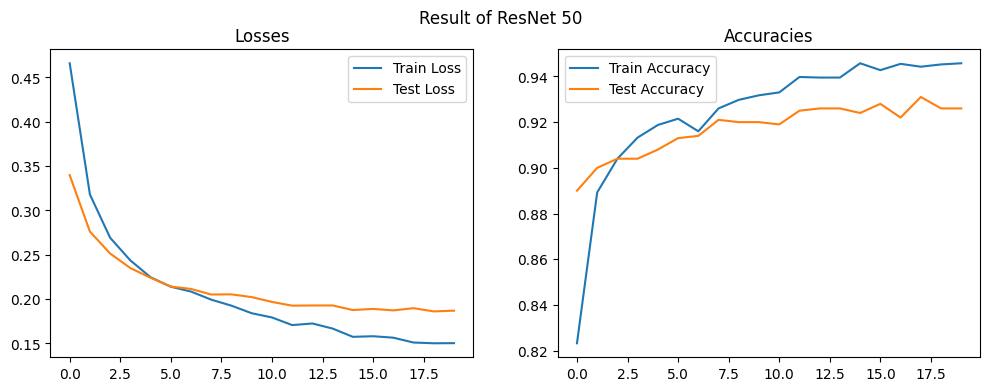

In [68]:
# plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Losses")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracies")
plt.legend()

plt.suptitle("Result of ResNet 50")

plt.show()

It turns out that after 20 epochs, the ResNet 50 model stagnated at an accuracy of 92%. Perhaps this can be optimized by changing the Optimizer, Learning Rate, and modifying the Fully Connected Layer by adding additional layers with varying numbers of neurons, adding Dropout because the model is slightly overfitting, and adding the ReLu activation function to each additional layer. This is experimental, and different cases may require different treatments as well.

## **9. Save The Model**

In [69]:
# 1. create models directory
model_path = Path("/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "01_gender_classification_pytorch_rn50.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model_rn50.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/01_gender_classification_pytorch_rn50.pth


## **10. Making Prediction**

In [73]:
# load the trained model
model_path = "/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/01_gender_classification_pytorch_rn50.pth"
model_loaded = resnet50(weights=None)  # load pre-trained ResNet50 architecture
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = torch.nn.Linear(num_ftrs, 1)  # assuming binary classification
model_loaded.load_state_dict(torch.load(model_path))
model_loaded.eval()

# define transformations for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

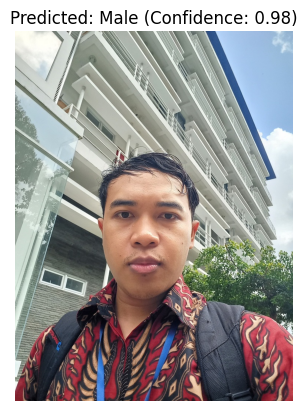

In [79]:
# load and preprocess the input image
image_path = "/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/Foto Profil 1.jpeg"  # provide the path to your input image
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # add a batch dimension

# perform prediction
with torch.no_grad():
    output = torch.sigmoid(model_loaded(image_tensor))

# convert prediction to human-readable label
predicted_class = "Male" if output.item() > 0.5 else "Female"
confidence = output.item() if output.item() > 0.5 else 1 - output.item()

# display the image with prediction label and accuracy
plt.imshow(image)
plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

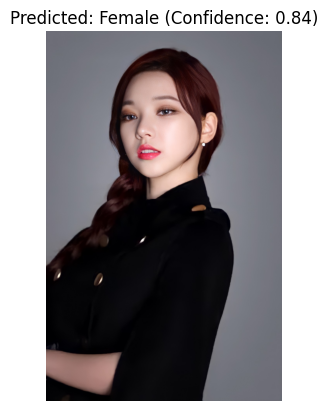

In [80]:
# load and preprocess the input image
image_path = "/content/drive/MyDrive/Dataset/project_cv_1_FaceRecognition/karina.jpg"  # provide the path to your input image
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # add a batch dimension

# perform prediction
with torch.no_grad():
    output = torch.sigmoid(model_loaded(image_tensor))

# convert prediction to human-readable label
predicted_class = "Male" if output.item() > 0.5 else "Female"
confidence = output.item() if output.item() > 0.5 else 1 - output.item()

# display the image with prediction label and accuracy
plt.imshow(image)
plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


The trained ResNet 50 model successfully predicted male and female photos. Thus, this experiment is concluded. This experiment is far from perfect, so there is still room for improvement in the future to make the model used faster and more efficient. Additionally, the codes used should be made more efficient, such as being encapsulated into functions for more efficient coding, ease of use, and traceability. After the experiment, it is advisable to organize the core codes of model development into modular formats to facilitate deployment processes to specific platforms or applications. Thank you.